# Step 0: Imports

In [1]:
# using tqdm.auto glitches out collaborative editing
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib as mpl
import matplotlib.pyplot as plt, mpld3

from math import sqrt
from collections import deque
import os
import random
from concurrent.futures import ProcessPoolExecutor
import pickle

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda", "CUDA is not available. Please check your GPU setup."

In [2]:
# VTXS numbers here are inclusive
MIN_VTXS = 3
MAX_VTXS = 15
MAX_TUNE_VTXS = 7
AVG_DEG = 2
SEQ_LEN = MAX_VTXS + 1 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
EPOCH_SIZE = 2**20
# vertices are labelled 1,2,...,MAX_VTXS
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [158]:
# original task data
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n) for _ in range(AVG_DEG * n)]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            if u < v:
                edge_list += [u, v]
            else:
                edge_list += [v, u]
            adjacencies[u].add(v)
            adjacencies[v].add(u)
    edge_list += [PAD_TOKEN]*(2*SEQ_LEN-1-len(edge_list))
    return edge_list, adjacencies

def SSSP(G, target=2, distonly=True):
    dist = [MAX_VTXS] * len(G)
    parent = [-1] * len(G)
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == MAX_VTXS:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    if distonly:
                        return dist[x]
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return MAX_VTXS if distonly else []

# large: size up to MAX_VTXS instead of MAX_TUNE_VTXS
# target: 2, "onpath", "any"
# largetarget: whether can go up to MAX_VTXS or just MAX_TUNE_VTXS
def mkbatch(size, large=True, target=2, largetarget=True):
    graphs = []
    dists = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS if large else MAX_TUNE_VTXS)
        while True:
            edge_list, adj_list = random_graph(n)
            if target == 2:
                # Train data
                dist = SSSP(adj_list)
                # Filter out some short distance graphs
                if 6 <= dist < MAX_VTXS or (dist < 6 and 2 * random.random() < 1 / (6 - dist)) or (dist == MAX_VTXS and random.random() < 1 / MAX_VTXS):
                    edge_list[-1] = 2
                    break
            elif target == "onpath":
                path = SSSP(adj_list, 2, False)
                dist = len(path) - 1
                # Filter out some short distance graphs
                if dist < 1 or (not large and dist < 4 and 3 * random.random() > 1 / (4 - dist)):
                    continue
                dist = random.choices(range(1, len(path)), weights=range(1, len(path)))[0]
                if (largetarget or path[dist] <= MAX_TUNE_VTXS):
                    edge_list[-1] = path[dist]
                    break
            elif target == "any":
                edge_list[-1] = random.randint(2, MAX_VTXS if largetarget else MAX_TUNE_VTXS)
                dist = SSSP(adj_list, edge_list[-1])
                break
        graphs.append(edge_list)
        dists.append(dist)
    
    data = torch.tensor(graphs)
    labels = torch.tensor(dists, dtype=torch.float32)
    padding = data == PAD_TOKEN
    return data, labels, padding

def savebatch(size, idx):
    data, labels, padding = mkbatch(size)
    everything = {
        "data": data,
        "labels": labels,
        "padding": padding,
    }
    
    with open(f'data-new/{idx}.pickle', 'wb') as file:
        pickle.dump(everything, file)

In [4]:
# Only need to run this once to generate training data
# RESTART THE KERNEL BEFORE RUNNING AND ONLY RUN THE CELLS ABOVE
# Python is slow and awful

# with ProcessPoolExecutor() as executor:
#     for i in range(64):
#         executor.submit(savebatch, EPOCH_SIZE, i)
#     executor.shutdown()

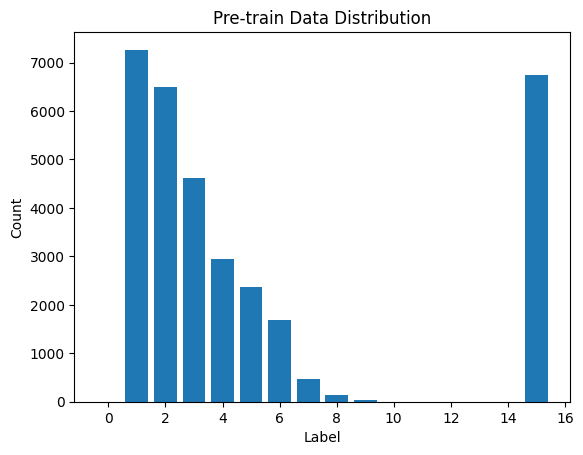

In [48]:
bins = torch.bincount(mkbatch(2**15)[1].to(torch.uint8).cpu())
plt.bar(range(len(bins)), bins)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Pre-train Data Distribution")
with open("plots/train-dist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

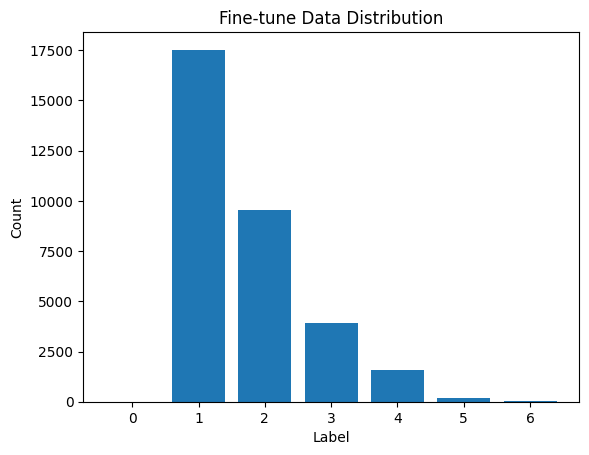

In [136]:
bins = torch.bincount(mkbatch(2**15, large=False, target="onpath")[1].to(torch.uint8).cpu())
plt.bar(range(len(bins)), bins)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Fine-tune Data Distribution")
with open("plots/tune-dist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

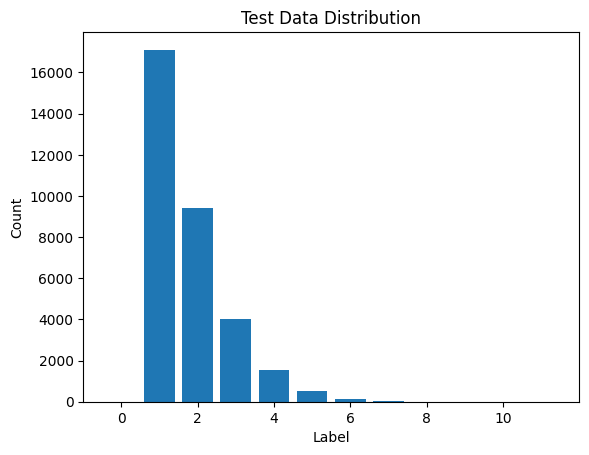

In [152]:
bins = torch.bincount(mkbatch(2**15, large=True, target="onpath", largetarget=False)[1].to(torch.uint8).cpu())
plt.bar(range(len(bins)), bins)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Test Data Distribution")
with open("plots/test-dist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

# Step 2: Define Transformer Model

In [138]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.embedding = nn.Embedding(input_dim, model_dim // 2)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim)

    def forward(self, src, key_padding_mask):
        batch_sz = src.size(0)
        src = torch.cat((src, torch.full((batch_sz, 1), MAX_VTXS + 1, device=device)), dim=1)
        embed = torch.cat((self.embedding(src[:,::2]), self.embedding(src[:,1::2])), dim=2)
        output = self.transformer_encoder(embed, src_key_padding_mask=key_padding_mask[:, ::2])
        return self.fc_out(output[:, -1, :])

# Step 3: Make Model

In [139]:
# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS + 1 # pad plus max number of vertices plus target token
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 300
BSZ = 2**15 # Batch size
NHEADS = 2
NLAYERS = 11
DROPOUT = 0 # 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT).to(device)
model = torch.compile(model)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training data: {NEPOCHS*EPOCH_SIZE//10**3}K")
print(f"Trainable parameters in the model: {trainable_params}")

train_err = []
len1 = []
len2 = []
len3 = []
leninf = []
epoch = 0

# clear loss file
open('loss', 'w').close()

Training data: 314572K
Trainable parameters in the model: 550433


In [140]:
# model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
#                          output_dim=1, num_heads=NHEADS,
#                          num_layers=NLAYERS, seq_len=SEQ_LEN,
#                          dropout=DROPOUT).to(device)
# model = torch.compile(model)
# model.load_state_dict(torch.load('model.pth', weights_only=True))

LR = 1e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Step 4: Train the Model for the first task

In [32]:
while epoch < NEPOCHS:
    model.train()
    with open(f"data-new/{epoch}.pickle", "rb") as f:
        pickled_stuff = pickle.load(f)
    data = pickled_stuff["data"].to(device)
    label = pickled_stuff["labels"].to(device).to(torch.float32)
    padding = pickled_stuff["padding"].to(device)
    dataset = TensorDataset(data, label, padding)
    loader = DataLoader(dataset, batch_size=BSZ)
    for batch_src, batch_labels, batch_padding_mask in tqdm(loader):
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        loss.backward()
        optimizer.step()
        
        train_err.append(loss.item())
        len1.append(criterion(output[batch_labels == 1].squeeze(1), batch_labels[batch_labels == 1]).item())
        len2.append(criterion(output[batch_labels == 2].squeeze(1), batch_labels[batch_labels == 2]).item())
        len3.append(criterion(output[batch_labels == 3].squeeze(1), batch_labels[batch_labels == 3]).item())
        leninf.append(criterion(output[batch_labels == MAX_VTXS].squeeze(1), batch_labels[batch_labels == MAX_VTXS]).item())
        
        with open('loss', 'a') as f:
            f.write(f"{train_err[-1]} {len1[-1]} {len2[-1]} {len3[-1]} {leninf[-1]}\n")
    epoch_err = lambda l: sum(l[-EPOCH_SIZE // BSZ:]) / EPOCH_SIZE * BSZ
    print(f"Epoch {epoch}/{NEPOCHS} \t Train Err: {epoch_err(train_err)} {epoch_err(len1)} {epoch_err(len2)} {epoch_err(len3)} {epoch_err(leninf)}")

    epoch += 1
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"checkpoints/model_weights_{epoch}.pth")


00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 200/300 	 Train Err: 0.009700538314064033 0.0010365489144987805 0.0014181289396901775 0.0025550971085976926 0.0037460410569565283



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 201/300 	 Train Err: 0.006831652077380568 7.503824454602182e-05 9.871918865655971e-05 0.0007692588069403428 0.004252040160537263



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 202/300 	 Train Err: 0.006540725109516643 2.3946865439938847e-05 4.20242082554978e-05 0.000602365005761385 0.002779622270679738



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 203/300 	 Train Err: 0.006822258495958522 3.6414980883137105e-05 6.143140507219869e-05 0.0006219874312591855 0.003169983861084802



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 204/300 	 Train Err: 0.006038466963218525 2.4559519403055674e-05 3.5345615970072686e-05 0.0005455858222376264 0.0026163237602645495



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 205/300 	 Train Err: 0.006186740662087686 3.194489249835897e-05 4.294817205163781e-05 0.0005785539024145692 0.0024907126505127053



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 206/300 	 Train Err: 0.005865870829438791 3.5813305146348284e-05 4.379174754376436e-05 0.0005817442843181198 0.0024162692638469707



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 207/300 	 Train Err: 0.005545882100705057 3.600231397626885e-05 4.1314136637993215e-05 0.000594669256315683 0.0013424500369580983



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 208/300 	 Train Err: 0.005720494489651173 3.859014077534084e-05 4.535487767043378e-05 0.0006117928719504562 0.0023836229374580853



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 209/300 	 Train Err: 0.0055108592205215245 4.586832275776942e-05 4.0804587058573816e-05 0.0005661740378855029 0.0030462031715501325



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 210/300 	 Train Err: 0.005376759043429047 3.36051924136882e-05 2.9235137617433793e-05 0.0005097897928862949 0.002858400079929879



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 211/300 	 Train Err: 0.005853716938872822 2.940421961739048e-05 3.749220735471681e-05 0.0004930990489810938 0.003736929087807539



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 212/300 	 Train Err: 0.005851926427567378 4.79271157871608e-05 6.914466911212003e-05 0.0006478189106928767 0.0024831123845956427



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 213/300 	 Train Err: 0.006799800234148279 5.7865587223204784e-05 9.293013340538891e-05 0.0007397326644422719 0.0039469943152141695



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 214/300 	 Train Err: 0.005759138788562268 3.775120410409727e-05 5.748265243710193e-05 0.0006046978646736534 0.004287633692598547



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 215/300 	 Train Err: 0.005322410768712871 4.7106011834330275e-05 6.199689340746772e-05 0.0004951892847202544 0.001372809862331792



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 216/300 	 Train Err: 0.00555990070279222 4.190891476696379e-05 5.821139978934298e-05 0.0005380580719247519 0.0035210271687731165



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 217/300 	 Train Err: 0.004976086333044805 7.500407750171689e-05 7.286436925824091e-05 0.0004962704629178916 0.0015869929502514424



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 218/300 	 Train Err: 0.005077980022178963 4.628878488688315e-05 6.263833648745276e-05 0.0005214507327764295 0.0021321314072508812



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 219/300 	 Train Err: 0.0049016569028026424 3.899440955024147e-05 3.9328363271806666e-05 0.0005199085585445573 0.0025905770780241255



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 220/300 	 Train Err: 0.005104515570565127 3.7041234861590056e-05 4.9192609594683745e-05 0.000491508646064176 0.002698791566103864



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 221/300 	 Train Err: 0.0053775256528751925 8.40174562881657e-05 8.321028616364856e-05 0.0006354096440190915 0.002188114008376374



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 222/300 	 Train Err: 0.005235390446614474 6.318601433008553e-05 0.00011316225950963599 0.0005508687736437423 0.003185757487855767



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 223/300 	 Train Err: 0.005300909557263367 7.39117677142076e-05 0.00011925572943027873 0.0005487319253916212 0.002978381860572199



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 224/300 	 Train Err: 0.004497841160628013 5.9339764732158073e-05 6.96952459975364e-05 0.0005027879551562364 0.001782914390517476



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 225/300 	 Train Err: 0.004688454842835199 7.675816877394936e-05 0.00010453435777435516 0.0005171399702703638 0.0028854877792241496



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 226/300 	 Train Err: 0.004642922693165019 7.117038816772947e-05 6.250007260177881e-05 0.00053063289669808 0.00242330242127764



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 227/300 	 Train Err: 0.004380291829875205 4.348535961185007e-05 6.43278998779806e-05 0.00042627666130101716 0.0024958747199974596



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 228/300 	 Train Err: 0.004652515672205482 4.8108470394936376e-05 6.366262556412039e-05 0.00046550729939554003 0.002803799277046437



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 229/300 	 Train Err: 0.004113680275622755 3.100523605326089e-05 4.310856323286316e-05 0.0004433248200257367 0.0022460650430957685



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 230/300 	 Train Err: 0.004635281045921147 4.207487796747955e-05 6.043314004955391e-05 0.0005022242676204769 0.0024831719019289267



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 231/300 	 Train Err: 0.005110396894451696 0.0001983720651708154 0.0002375991614940176 0.0008774314223956026 0.002636964950681886



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 232/300 	 Train Err: 0.0049849917777464725 0.0001501558316192586 0.00024557938434099924 0.0007316948017432878 0.0021723491789202853



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 233/300 	 Train Err: 0.004696133633842692 0.00010220188283938114 0.00014721588598831659 0.0006821819579272415 0.0023902068645895724



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 234/300 	 Train Err: 0.004084704407432582 5.2511502758534334e-05 6.844933011507237e-05 0.00047021749242048827 0.002734669448628324



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 235/300 	 Train Err: 0.003639004957221914 5.903515790350866e-05 8.000035580835174e-05 0.0003796246064666775 0.001738929542312917



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 236/300 	 Train Err: 0.003710617238539271 2.977514947133386e-05 3.8898698477396465e-05 0.0003604722842283081 0.0009449759105422117



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 237/300 	 Train Err: 0.003989764125435613 3.9895228240993674e-05 5.16856140109212e-05 0.00045158102011555457 0.001674787971268188



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 238/300 	 Train Err: 0.0052436307014431804 0.00013858247947950986 0.00022083272577333446 0.0008545901869183581 0.00233671873354524



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 239/300 	 Train Err: 0.004502967931330204 0.00010209598895016825 9.616378500254541e-05 0.00048576207518635783 0.0015566766385006758



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 240/300 	 Train Err: 0.00395154607394943 2.4841689480581408e-05 3.481786328052294e-05 0.0003626737070590025 0.002694538376630362



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 241/300 	 Train Err: 0.004540074682154227 7.381854948107502e-05 9.893310834740987e-05 0.0005228228733358264 0.0026238594035135065



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 242/300 	 Train Err: 0.004094215779332444 5.668814941373057e-05 8.304187170438126e-05 0.00044306572590357973 0.002081132290115306



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 243/300 	 Train Err: 0.003913102438673377 4.585197802953189e-05 5.789757997831657e-05 0.0013291612922330387 0.0020740707810062986



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 244/300 	 Train Err: 0.004195565263216849 3.806313242193937e-05 5.340812001008999e-05 0.00041497633492326713 0.002989801170187434



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 245/300 	 Train Err: 0.004047608803375624 6.732485988436565e-05 9.67713261843528e-05 0.0005451126739899337 0.002438096437799686



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 246/300 	 Train Err: 0.004089277834282257 6.664293536573496e-05 9.393133385060537e-05 0.0004827346115234832 0.0017539746410619728



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 247/300 	 Train Err: 0.0035380944900680333 9.052370739937032e-05 0.00011764369932620866 0.0006084945985094237 0.0011799170262918324



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 248/300 	 Train Err: 0.0035020401555811986 3.0666821288605206e-05 4.465118504981547e-05 0.0003278196218161611 0.0018799946564627135



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 249/300 	 Train Err: 0.004724001191789284 9.285189429419916e-05 0.00012808766365424162 0.0004897935516510188 0.00302792190994694



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 250/300 	 Train Err: 0.004049119248520583 7.58403711529354e-05 9.593046939926353e-05 0.0004770750299485371 0.0026782418092778926



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 251/300 	 Train Err: 0.003661572525743395 4.6462737600450055e-05 5.566726716210724e-05 0.0004296750569210417 0.002789238562314722



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 252/300 	 Train Err: 0.003436399820202496 4.064976889139871e-05 5.003276532988821e-05 0.00038082731816757587 0.002257287138661468



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 253/300 	 Train Err: 0.003201432766218204 3.2443880314758644e-05 3.860860113036324e-05 0.00032383076040787273 0.0012120022082626747



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 254/300 	 Train Err: 0.003311082960863132 4.5200399654277135e-05 6.019428829517892e-05 0.00033768308026083105 0.0017057321817901538



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 255/300 	 Train Err: 0.003727161471033469 8.389212513293387e-05 0.00011534792562883922 0.00044301021353021497 0.0015780800986391341



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 256/300 	 Train Err: 0.003738447092473507 8.379092363952623e-05 0.00011557144276252984 0.00045860962654842297 0.002139192058905337



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 257/300 	 Train Err: 0.0034996949252672493 7.875290160086479e-05 0.00010191635280420996 0.0010230293487438757 0.0011676927765904566



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 258/300 	 Train Err: 0.0036751833540620282 4.3053820434124646e-05 5.797953258479538e-05 0.00033043701182577934 0.0026015445665450443



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 259/300 	 Train Err: 0.0030066172403167 2.8544642134420428e-05 3.4369389794619565e-05 0.00030651216297883366 0.0010866159546480958



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 260/300 	 Train Err: 0.003899131465004757 9.39390017435926e-05 0.00010894855989818097 0.000464337135781534 0.0015993566187972874



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 261/300 	 Train Err: 0.0027930525757255964 7.185203750736946e-05 9.880084232349873e-05 0.0003542822555573366 0.0008163415011068764



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 262/300 	 Train Err: 0.003117560874670744 0.00010307476776461044 0.00012391211180329265 0.00041415533542021876 0.0014386503646477422



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 263/300 	 Train Err: 0.003268079031840898 9.003786195194152e-05 8.649396028204137e-05 0.0004168724274222768 0.00150578541718005



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 264/300 	 Train Err: 0.0026079017552547157 2.246009304940344e-05 3.15551765197597e-05 0.0002907984498961014 0.0007710294869553991



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 265/300 	 Train Err: 0.0028374393659760244 2.585551322908941e-05 2.7533280416491834e-05 0.00028491684133769013 0.0010678084470185922



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 266/300 	 Train Err: 0.003345544362673536 4.9037233594617646e-05 6.386032035265998e-05 0.0003377324483153643 0.002303508839716528



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 267/300 	 Train Err: 0.0028792162775062025 6.944555900645355e-05 9.428040866055198e-05 0.00039187861466416507 0.0007993936363277498



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 268/300 	 Train Err: 0.0031112020296859555 4.3891389566397265e-05 4.875301172546642e-05 0.00027064218579653243 0.0017511903075018154



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 269/300 	 Train Err: 0.0030466990065178834 4.0109083158768044e-05 6.39344424371302e-05 0.0004256982326751313 0.0010282776493681922



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 270/300 	 Train Err: 0.0038976767973508686 0.00010299110641653897 0.0001073770393702489 0.0004656959667954652 0.001747739342135901



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 271/300 	 Train Err: 0.004126565829210449 0.00012952255988807337 0.00016465946305288526 0.0004091988171239791 0.002737868909463259



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 272/300 	 Train Err: 0.005586953229794744 0.00011988704233090175 8.92973938562136e-05 0.0008274920874100644 0.005225448500027596



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 273/300 	 Train Err: 0.003360286595125217 4.9669066697788367e-05 7.549639843773548e-05 0.00040038250972429523 0.0017126402361498094



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 274/300 	 Train Err: 0.0037096842715982348 0.00010263273924238092 0.00010759665562432019 0.0004499732262956968 0.002582911283610656



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 275/300 	 Train Err: 0.003157066814310383 4.581558967231558e-05 9.948560264660955e-05 0.0004738382222058135 0.0019836488944235953



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 276/300 	 Train Err: 0.003158892614010256 5.7304253459733445e-05 7.066275753686568e-05 0.0003324287613395427 0.0018403834514018058



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 277/300 	 Train Err: 0.002581501808890607 4.861700740832475e-05 6.541747751498406e-05 0.000284652207938052 0.0007380942764569909



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 278/300 	 Train Err: 0.0025860080822894815 2.174209052441256e-05 2.662913956896773e-05 0.00022730225418854388 0.0010037773529276706



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 279/300 	 Train Err: 0.002347265100979712 3.7067890659159275e-05 5.258349327164069e-05 0.00027653912843561557 0.0008076369083056534



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 280/300 	 Train Err: 0.0020991099227103405 4.95786165544132e-05 7.162138820149266e-05 0.00025381120440215454 0.00021227763140529987



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 281/300 	 Train Err: 0.002149274954717839 4.502804105754876e-05 5.465928461489966e-05 0.00020037225408486847 0.0008008158908197061



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 282/300 	 Train Err: 0.002332294654479483 5.822195592486423e-05 7.976816402788245e-05 0.00027342953717379714 0.0011204043772465866



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 283/300 	 Train Err: 0.002367243367189076 6.421889257524072e-05 7.192823628088263e-05 0.00027969777374892146 0.000926283852436427



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 284/300 	 Train Err: 0.0024702023074496537 4.001182000479275e-05 5.6243611766149115e-05 0.00028294666503825283 0.001745262754937471



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 285/300 	 Train Err: 0.00244181264861254 3.681690922974212e-05 4.3878520443740854e-05 0.0002598097414647782 0.0010403500756694939



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 286/300 	 Train Err: 0.004294504986319225 0.0001190346050776725 0.00014606812183615148 0.0005992255282762926 0.0030846270542213006



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 287/300 	 Train Err: 0.002652545867022127 4.383792450823876e-05 5.175098229415198e-05 0.00022583443728763086 0.0010033834210929626



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 288/300 	 Train Err: 0.0024623927056381945 4.488101473043571e-05 5.153768390186997e-05 0.0002487341471351101 0.0007657397355842477



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 289/300 	 Train Err: 0.0020869168256467674 1.6691098323917686e-05 2.3564317743307583e-05 0.00022000102012498246 0.00045439355731957676



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.06it/s]

Epoch 290/300 	 Train Err: 0.0022730279415554833 3.0484697447263898e-05 4.219567442476091e-05 0.00016836693907862355 0.001119111784291249



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 291/300 	 Train Err: 0.001991223918594187 2.1141308877759002e-05 3.04732807308028e-05 0.00020811638796658372 0.0003465958211279485



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 292/300 	 Train Err: 0.002292186658451101 3.154981907016463e-05 4.474536956422526e-05 0.00023634338492684037 0.0009605502598901694



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 293/300 	 Train Err: 0.0026851176444324665 4.017607729167594e-05 5.052340833344715e-05 0.0002948304424990056 0.0016830961768476982



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 294/300 	 Train Err: 0.0034057760349242017 7.469349623079324e-05 8.74023012897851e-05 0.000339981324486871 0.003754490641924235



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 295/300 	 Train Err: 0.0030984806799096987 0.00010745276432544415 9.293096556461933e-05 0.00044971922284275934 0.001608260552785623



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 296/300 	 Train Err: 0.0046719673155166674 0.0002628431795983488 0.0001992497713558805 0.0007588743333144521 0.00447205124172001



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 297/300 	 Train Err: 0.0029889549914514646 3.997794847521163e-05 5.749405914912131e-05 0.0002763791262623272 0.0008012855590209256



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.05it/s]

Epoch 298/300 	 Train Err: 0.0024420233276032377 2.269027612555874e-05 2.9261659733492706e-05 0.0002353174338622921 0.001323332107006081


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 299/300 	 Train Err: 0.0022801305785833392 5.704613654700097e-05 7.387786931190021e-05 0.0002796662083710544 0.0008495270817547862


In [85]:
def evaluate(data):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), data)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return output.detach(), batch_labels.detach().to(torch.uint8), loss.item()

def mkhist(data, title):
    y, x, loss = evaluate(data)
    print(loss)
    cnts = torch.bincount(x)
    weights = [1/cnts[i.item()].item() for i in x] # normalize by label count
    fig, ax = plt.subplots()
    h = ax.hist2d(x.cpu().numpy().flatten(), y.cpu().numpy().flatten(), weights=weights, bins=[cnts.shape[0] - 1, 50], norm=mpl.colors.LogNorm())
    ax.set_xlabel("Label")
    ax.set_ylabel("Model Output")
    ax.set_title(title)
    fig.colorbar(h[3], ax=ax)
    return fig

In [141]:
evaluate(mkbatch(BSZ))[2]

0.0019329296192154288

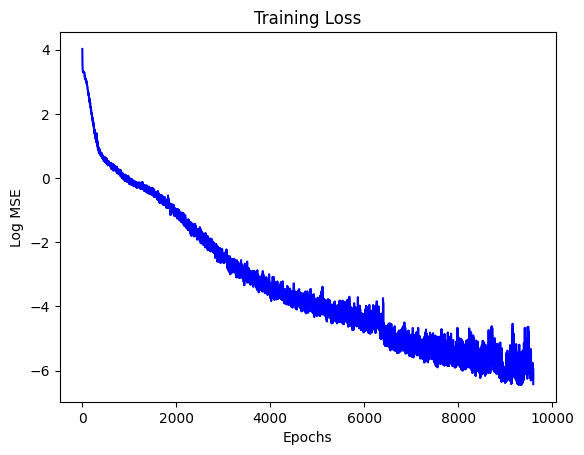

In [49]:
with open('loss') as f:
    losses = torch.tensor([list(map(float, l.split())) for l in f.readlines()])
plt.plot(torch.log(losses[:, 0]), label='Train', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Log MSE')
plt.title('Training Loss')
with open("plots/train-loss.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

0.002062194049358368


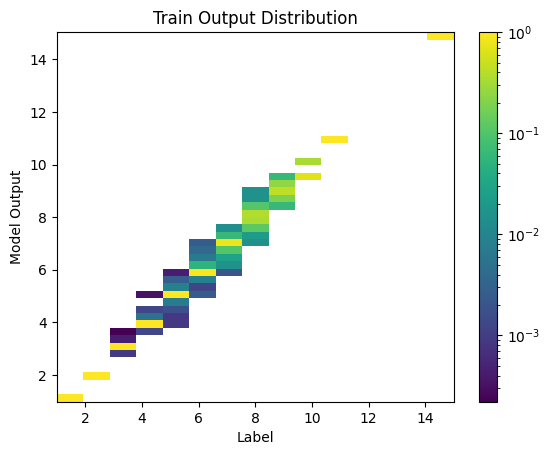

In [116]:
fig = mkhist(mkbatch(BSZ), "Train Output Distribution")
with open("plots/train-hist.html", "w") as f:
    mpld3.save_html(fig, f)

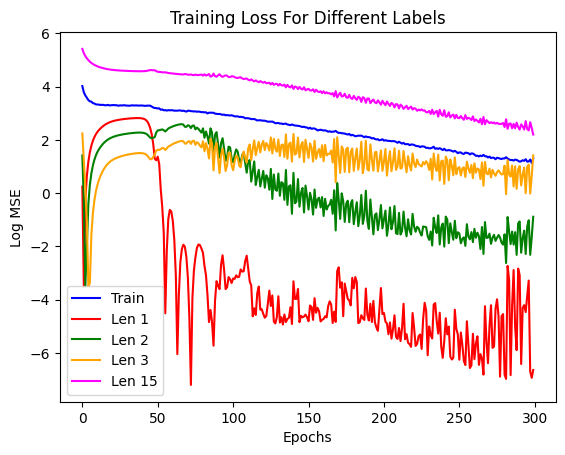

In [50]:
plt.plot(torch.log(losses[:300, 0]), label='Train', color='blue')
plt.plot(torch.log(losses[:300, 1]), label='Len 1', color='red')
plt.plot(torch.log(losses[:300, 2]), label='Len 2', color='green')
plt.plot(torch.log(losses[:300, 3]), label='Len 3', color='orange')
plt.plot(torch.log(losses[:300, 4]), label='Len 15', color='magenta')
plt.xlabel('Epochs')
plt.ylabel('Log MSE')
plt.title('Training Loss For Different Labels')
plt.legend()
with open("plots/train-lens.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

In [180]:
# Testing line graph
inp = torch.cat((torch.repeat_interleave(torch.arange(2, MAX_VTXS + 1), 2)[1:-1], torch.tensor([1, 15, 0, 0, 2]))).unsqueeze(0).to(device)
print(inp)
model(inp, inp == PAD_TOKEN)

tensor([[ 2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11,
         11, 12, 12, 13, 13, 14, 14, 15,  1, 15,  0,  0,  2]], device='cuda:0')


tensor([[7.1840]], device='cuda:0', grad_fn=<CompiledFunctionBackward>)

# Step 5: Fine Tune

In [142]:
N_TUNE_EPOCHS = 100
TUNE_LR = 1e-5

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR)

tune_train_err = []

# clear loss file
open('tune_loss', 'w').close()

In [143]:
for epoch in range(N_TUNE_EPOCHS):
    model.train()
    train_loss = 0
    batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ, large=False, target="onpath"))
    optimizer.zero_grad()
    output = model(batch_src, batch_padding_mask)
    loss = criterion(output.squeeze(1), batch_labels)
    train_loss = loss.item()
    loss.backward()
    optimizer.step()
    
    tune_train_err.append(train_loss)
    with open('tune_loss', 'a') as f:
        f.write(f"{train_loss}\n")
    print(f"Epoch {epoch}/{N_TUNE_EPOCHS} \t Train Err: {train_loss}")

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"checkpoints/tune_model_weights_{epoch + 1}.pth")

Epoch 0/100 	 Train Err: 0.5544188022613525
Epoch 1/100 	 Train Err: 0.3685164451599121
Epoch 2/100 	 Train Err: 0.3081561028957367
Epoch 3/100 	 Train Err: 0.34435540437698364
Epoch 4/100 	 Train Err: 0.34420037269592285
Epoch 5/100 	 Train Err: 0.3113354742527008
Epoch 6/100 	 Train Err: 0.2920008897781372
Epoch 7/100 	 Train Err: 0.29242873191833496
Epoch 8/100 	 Train Err: 0.29623904824256897
Epoch 9/100 	 Train Err: 0.289389967918396
Epoch 10/100 	 Train Err: 0.2864971160888672
Epoch 11/100 	 Train Err: 0.275798499584198
Epoch 12/100 	 Train Err: 0.26332974433898926
Epoch 13/100 	 Train Err: 0.24548597633838654
Epoch 14/100 	 Train Err: 0.23320920765399933
Epoch 15/100 	 Train Err: 0.21942488849163055
Epoch 16/100 	 Train Err: 0.2166539430618286
Epoch 17/100 	 Train Err: 0.199913889169693
Epoch 18/100 	 Train Err: 0.18155084550380707
Epoch 19/100 	 Train Err: 0.16955474019050598
Epoch 20/100 	 Train Err: 0.1510634422302246
Epoch 21/100 	 Train Err: 0.14870578050613403
Epoch 22/100

In [144]:
evaluate(mkbatch(BSZ, large=False, target="onpath"))[2]

0.00539579801261425

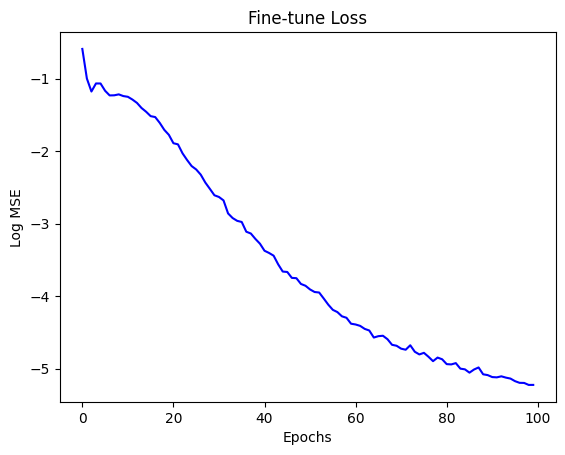

In [145]:
plt.plot(torch.log(torch.tensor(tune_train_err)), label="Train", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Log MSE")
plt.title("Fine-tune Loss")
with open("plots/tune-loss.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

0.005263924598693848


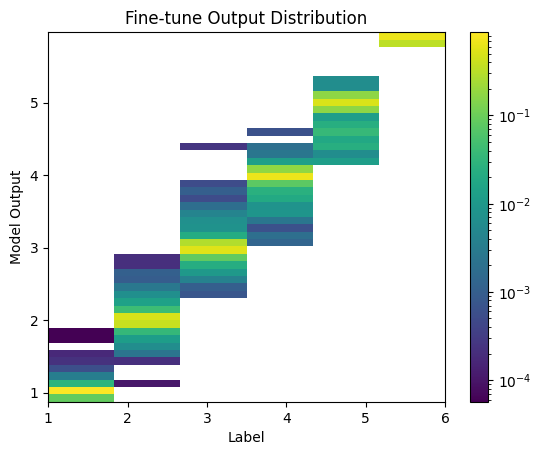

In [146]:
mkhist(mkbatch(BSZ, large=False, target="onpath"), "Fine-tune Output Distribution")
with open("plots/tune-hist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

# Step 6: Test generalization

0.09692102670669556


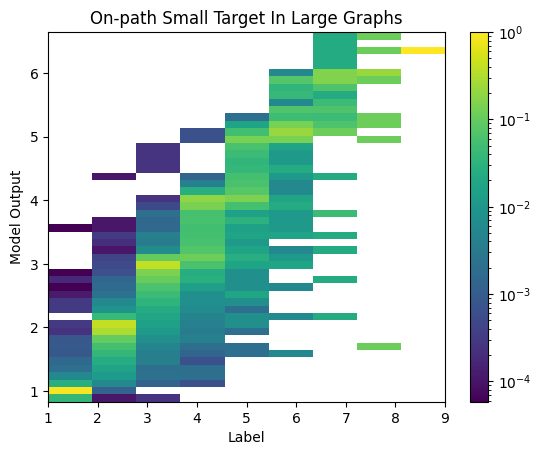

In [159]:
mkhist(mkbatch(BSZ, large=True, target="onpath", largetarget=False), "On-path Small Target In Large Graphs")
with open("plots/test-onpath-smalltarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

0.13019351661205292


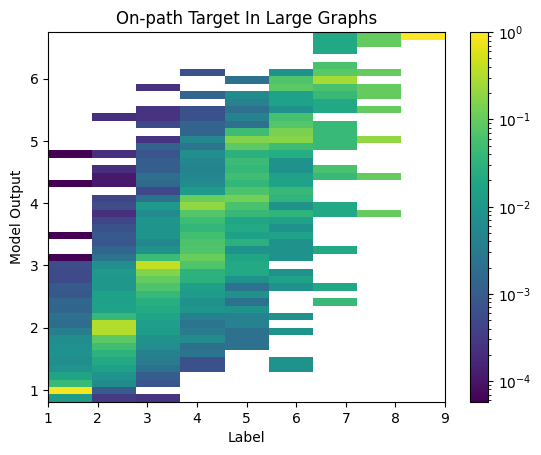

In [160]:
mkhist(mkbatch(BSZ, large=True, target="onpath", largetarget=True), "On-path Target In Large Graphs")
with open("plots/test-onpath-largetarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

65.92536926269531


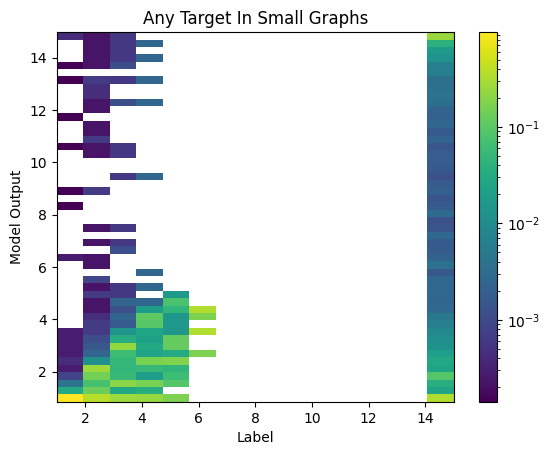

In [89]:
mkhist(mkbatch(BSZ, large=False, target="any", largetarget=False), "Any Target In Small Graphs")
with open("plots/test-small-any.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

52.1881217956543


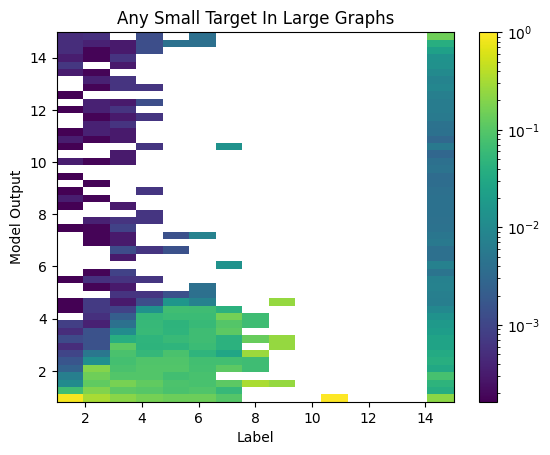

In [90]:
mkhist(mkbatch(BSZ, large=True, target="any", largetarget=False), "Any Small Target In Large Graphs")
with open("plots/test-large-any-smalltarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

81.48127746582031


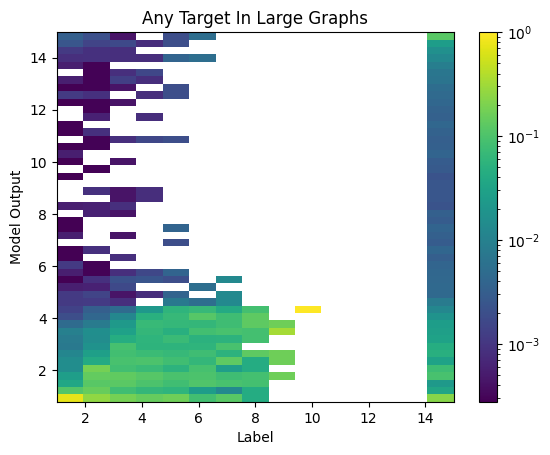

In [91]:
mkhist(mkbatch(BSZ, large=True, target="any", largetarget=True), "Any Target In Large Graphs")
with open("plots/test-large-any-largetarget.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)